# 🎯 Ensemble de Modelos
## Combinación de modelos para mejorar rendimiento

### Objetivos:
1. Implementar Voting Classifier
2. Implementar Stacking Classifier
3. Comparar ensemble vs modelos individuales
4. Evaluar si mejora el rendimiento
5. Seleccionar mejor ensemble


## 1. Importar librerías


In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Añadir src al path
sys.path.append(str(Path('../src').resolve()))

from models.ensemble import create_voting_classifier, create_stacking_classifier, compare_ensemble_vs_individual
from models.train import train_model, save_model
from models.evaluate import evaluate_model
from features.vectorization import load_vectorized_data

print("✅ Librerías importadas")


✅ Librerías importadas


## 2. Cargar datos vectorizados


In [2]:
# Cargar datos vectorizados con TF-IDF
data_dir = Path('../data/processed')
X_train_tfidf, X_test_tfidf, y_train, y_test = load_vectorized_data(data_dir, prefix='tfidf')

print(f"✅ Datos cargados:")
print(f"   Train: {X_train_tfidf.shape}")
print(f"   Test: {X_test_tfidf.shape}")
print(f"   Labels - Train: {len(y_train)}, Test: {len(y_test)}")


✅ Datos vectorizados cargados desde: ../data/processed
✅ Datos cargados:
   Train: (800, 1000)
   Test: (200, 1000)
   Labels - Train: 800, Test: 200


## 3. Entrenar modelos individuales para el ensemble


In [3]:
print("="*80)
print("ENTRENANDO MODELOS INDIVIDUALES PARA ENSEMBLE")
print("="*80)
print("⚠️  Usando parámetros optimizados para reducir overfitting\n")

# Entrenar modelos con parámetros optimizados para reducir overfitting
individual_models = {}

# 1. SVM (parámetros optimizados del hyperparameter tuning)
print("\n🔵 Entrenando SVM (optimizado)...")
individual_models['SVM'] = train_model(
    'svm', X_train_tfidf, y_train,
    C=0.056, kernel='linear', class_weight='balanced'  # Parámetros optimizados
)

# 2. Logistic Regression (con mayor regularización)
print("\n🟢 Entrenando Logistic Regression (optimizado)...")
individual_models['Logistic Regression'] = train_model(
    'logistic', X_train_tfidf, y_train,
    C=0.1, penalty='l2', class_weight='balanced', max_iter=1000  # Mayor regularización
)

# 3. Naive Bayes (con mayor regularización)
print("\n🟡 Entrenando Naive Bayes (optimizado)...")
individual_models['Naive Bayes'] = train_model(
    'naive_bayes', X_train_tfidf, y_train,
    alpha=10.0  # Mayor regularización
)

# 4. Random Forest (con mayor regularización)
print("\n🔴 Entrenando Random Forest (optimizado)...")
individual_models['Random Forest'] = train_model(
    'random_forest', X_train_tfidf, y_train,
    n_estimators=50, max_depth=5, min_samples_split=10, 
    min_samples_leaf=5, class_weight='balanced'  # Mayor regularización
)

print(f"\n✅ {len(individual_models)} modelos entrenados con parámetros optimizados")


ENTRENANDO MODELOS INDIVIDUALES PARA ENSEMBLE
⚠️  Usando parámetros optimizados para reducir overfitting


🔵 Entrenando SVM (optimizado)...

🟢 Entrenando Logistic Regression (optimizado)...

🟡 Entrenando Naive Bayes (optimizado)...

🔴 Entrenando Random Forest (optimizado)...

✅ 4 modelos entrenados con parámetros optimizados


## 4. Crear Voting Classifier (Soft Voting)


In [4]:
print("="*80)
print("CREANDO VOTING CLASSIFIER (SOFT VOTING)")
print("="*80)
print("⚠️  Usando parámetros optimizados automáticamente\n")

# Configuración básica de modelos (los parámetros optimizados se aplicarán automáticamente)
models_config = [
    {'name': 'svm', 'type': 'svm', 'params': {}},  # Parámetros optimizados se aplican automáticamente
    {'name': 'logistic', 'type': 'logistic', 'params': {}},
    {'name': 'naive_bayes', 'type': 'naive_bayes', 'params': {}},
    {'name': 'random_forest', 'type': 'random_forest', 'params': {}}
]

# Crear Voting Classifier con soft voting y parámetros optimizados
voting_clf = create_voting_classifier(
    models_config,
    X_train_tfidf,
    y_train,
    voting='soft',
    use_optimized_params=True  # Activar parámetros optimizados
)

# Evaluar
print("\n" + "="*80)
print("EVALUACIÓN VOTING CLASSIFIER")
print("="*80)
results_voting = evaluate_model(
    voting_clf, X_train_tfidf, X_test_tfidf, y_train, y_test
)


CREANDO VOTING CLASSIFIER (SOFT VOTING)
⚠️  Usando parámetros optimizados automáticamente

✅ Voting Classifier creado con 4 modelos
   Tipo de votación: soft

EVALUACIÓN VOTING CLASSIFIER
RESULTADOS DE EVALUACIÓN

📊 MÉTRICAS EN TRAIN:
   Accuracy:  0.8063
   Precision: 0.9498
   Recall:    0.6135
   F1-score:  0.7455

📊 MÉTRICAS EN TEST:
   Accuracy:  0.6550
   Precision: 0.8108
   Recall:    0.3261
   F1-score:  0.4651

⚠️  OVERFITTING:
   Diferencia F1 (train-test): 28.04%
   ❌ Overfitting alto (>10%)

📋 Matriz de confusión (test):
[[101   7]
 [ 62  30]]


## 5. Crear Stacking Classifier


In [5]:
print("="*80)
print("CREANDO STACKING CLASSIFIER")
print("="*80)
print("⚠️  Usando parámetros optimizados automáticamente\n")

# Crear Stacking Classifier con parámetros optimizados
stacking_clf = create_stacking_classifier(
    models_config,
    X_train_tfidf,
    y_train,
    final_estimator=None,  # Usa LogisticRegression con C=0.1 (regularizado)
    cv=5,
    use_optimized_params=True  # Activar parámetros optimizados
)

# Evaluar
print("\n" + "="*80)
print("EVALUACIÓN STACKING CLASSIFIER")
print("="*80)
results_stacking = evaluate_model(
    stacking_clf, X_train_tfidf, X_test_tfidf, y_train, y_test
)


CREANDO STACKING CLASSIFIER
⚠️  Usando parámetros optimizados automáticamente

✅ Stacking Classifier creado con 4 modelos
   Cross-validation: 5 folds
   Estimador final: LogisticRegression

EVALUACIÓN STACKING CLASSIFIER
RESULTADOS DE EVALUACIÓN

📊 MÉTRICAS EN TRAIN:
   Accuracy:  0.8575
   Precision: 0.8743
   Recall:    0.8081
   F1-score:  0.8399

📊 MÉTRICAS EN TEST:
   Accuracy:  0.7250
   Precision: 0.7342
   Recall:    0.6304
   F1-score:  0.6784

⚠️  OVERFITTING:
   Diferencia F1 (train-test): 16.15%
   ❌ Overfitting alto (>10%)

📋 Matriz de confusión (test):
[[87 21]
 [34 58]]


## 6. Comparar Ensemble vs Modelos Individuales


In [6]:
print("="*80)
print("COMPARACIÓN: ENSEMBLE VS MODELOS INDIVIDUALES")
print("="*80)

# Comparar Voting vs individuales
comparison_voting = compare_ensemble_vs_individual(
    voting_clf,
    individual_models,
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test
)

print("\n📊 Comparación Voting Classifier vs Individuales:")
print(comparison_voting.to_string(index=False))

# Comparar Stacking vs individuales
comparison_stacking = compare_ensemble_vs_individual(
    stacking_clf,
    individual_models,
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test
)

print("\n📊 Comparación Stacking Classifier vs Individuales:")
print(comparison_stacking.to_string(index=False))


COMPARACIÓN: ENSEMBLE VS MODELOS INDIVIDUALES

📊 Comparación Voting Classifier vs Individuales:
             Modelo  F1 (test)  F1 (train)  Overfitting (%)  Accuracy (test)  Precision (test)  Recall (test)
Logistic Regression   0.711864    0.825485        11.362036            0.745          0.741176       0.684783
                SVM   0.686567    0.711930         2.536300            0.580          0.522727       1.000000
      Random Forest   0.633540    0.755952        12.241201            0.705          0.739130       0.554348
           Ensemble   0.465116    0.745484        28.036812            0.655          0.810811       0.326087
        Naive Bayes   0.435484    0.740000        30.451613            0.650          0.843750       0.293478

📊 Comparación Stacking Classifier vs Individuales:
             Modelo  F1 (test)  F1 (train)  Overfitting (%)  Accuracy (test)  Precision (test)  Recall (test)
Logistic Regression   0.711864    0.825485        11.362036            0.745      

## 7. Visualización de resultados


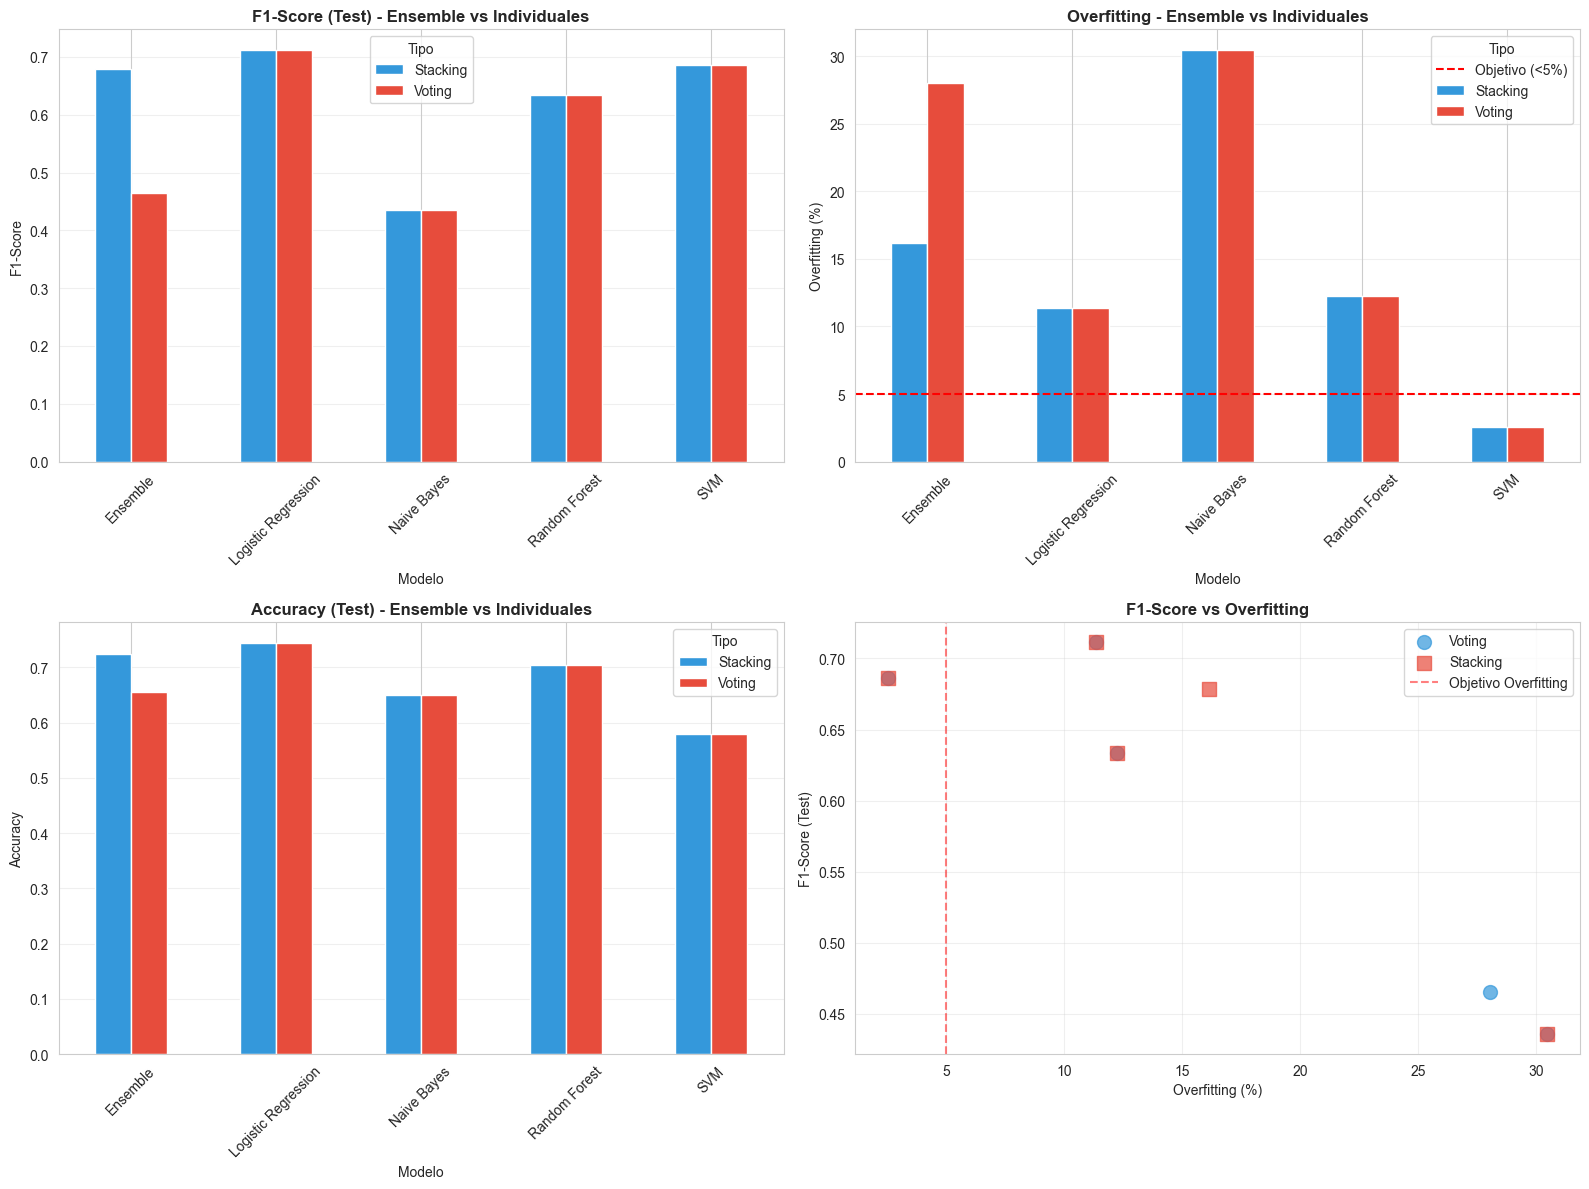

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-score comparación
comparison_all = pd.concat([
    comparison_voting.assign(Ensemble_Type='Voting'),
    comparison_stacking.assign(Ensemble_Type='Stacking')
])

# F1-score por modelo
pivot_f1 = comparison_all.pivot(index='Modelo', columns='Ensemble_Type', values='F1 (test)')
pivot_f1.plot(kind='bar', ax=axes[0, 0], color=['#3498db', '#e74c3c'])
axes[0, 0].set_title('F1-Score (Test) - Ensemble vs Individuales', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].set_xlabel('Modelo')
axes[0, 0].legend(title='Tipo')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Overfitting comparación
pivot_overfitting = comparison_all.pivot(index='Modelo', columns='Ensemble_Type', values='Overfitting (%)')
pivot_overfitting.plot(kind='bar', ax=axes[0, 1], color=['#3498db', '#e74c3c'])
axes[0, 1].axhline(y=5, color='r', linestyle='--', label='Objetivo (<5%)')
axes[0, 1].set_title('Overfitting - Ensemble vs Individuales', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Overfitting (%)')
axes[0, 1].set_xlabel('Modelo')
axes[0, 1].legend(title='Tipo')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Accuracy comparación
pivot_acc = comparison_all.pivot(index='Modelo', columns='Ensemble_Type', values='Accuracy (test)')
pivot_acc.plot(kind='bar', ax=axes[1, 0], color=['#3498db', '#e74c3c'])
axes[1, 0].set_title('Accuracy (Test) - Ensemble vs Individuales', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_xlabel('Modelo')
axes[1, 0].legend(title='Tipo')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Scatter: F1 vs Overfitting
axes[1, 1].scatter(
    comparison_all[comparison_all['Ensemble_Type'] == 'Voting']['Overfitting (%)'],
    comparison_all[comparison_all['Ensemble_Type'] == 'Voting']['F1 (test)'],
    label='Voting', s=100, alpha=0.7, color='#3498db', marker='o'
)
axes[1, 1].scatter(
    comparison_all[comparison_all['Ensemble_Type'] == 'Stacking']['Overfitting (%)'],
    comparison_all[comparison_all['Ensemble_Type'] == 'Stacking']['F1 (test)'],
    label='Stacking', s=100, alpha=0.7, color='#e74c3c', marker='s'
)
axes[1, 1].axvline(x=5, color='r', linestyle='--', alpha=0.5, label='Objetivo Overfitting')
axes[1, 1].set_xlabel('Overfitting (%)')
axes[1, 1].set_ylabel('F1-Score (Test)')
axes[1, 1].set_title('F1-Score vs Overfitting', fontweight='bold', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [8]:
# Comparar todos los modelos (ensembles + individuales)
all_results = {
    'Voting Classifier': results_voting,
    'Stacking Classifier': results_stacking
}

# Añadir modelos individuales
for name, model in individual_models.items():
    all_results[name] = evaluate_model(
        model, X_train_tfidf, X_test_tfidf, y_train, y_test, verbose=False
    )

# Crear comparación completa
from models.evaluate import compare_models
comparison_all = compare_models(all_results)

print("="*80)
print("COMPARACIÓN COMPLETA: TODOS LOS MODELOS")
print("="*80)
print("\n" + comparison_all.to_string(index=False))

# Seleccionar mejor modelo
good_models = comparison_all[comparison_all['Overfitting (%)'] < 5.0]

if len(good_models) > 0:
    best_model_name = good_models.iloc[0]['Modelo']
    best_model_results = all_results[best_model_name]
    print(f"\n🏆 MEJOR MODELO (Overfitting < 5%): {best_model_name}")
    print(f"   F1-score (test): {best_model_results['test_f1']:.4f}")
    print(f"   Overfitting: {best_model_results['diff_f1']:.2f}%")
    
    # Determinar qué modelo usar
    if 'Voting' in best_model_name:
        best_ensemble_model = voting_clf
        ensemble_type = 'voting'
    elif 'Stacking' in best_model_name:
        best_ensemble_model = stacking_clf
        ensemble_type = 'stacking'
    else:
        best_ensemble_model = individual_models.get(best_model_name)
        ensemble_type = 'individual'
else:
    # Si ningún modelo cumple, elegir el mejor F1
    best_model_name = comparison_all.iloc[0]['Modelo']
    best_model_results = all_results[best_model_name]
    print(f"\n⚠️  MEJOR MODELO (Overfitting > 5%): {best_model_name}")
    print(f"   F1-score (test): {best_model_results['test_f1']:.4f}")
    print(f"   Overfitting: {best_model_results['diff_f1']:.2f}%")
    
    if 'Voting' in best_model_name:
        best_ensemble_model = voting_clf
        ensemble_type = 'voting'
    elif 'Stacking' in best_model_name:
        best_ensemble_model = stacking_clf
        ensemble_type = 'stacking'
    else:
        best_ensemble_model = individual_models.get(best_model_name)
        ensemble_type = 'individual'


COMPARACIÓN COMPLETA: TODOS LOS MODELOS

             Modelo  F1 (test)  F1 (train)  Overfitting (%)  Accuracy (test)  Precision (test)  Recall (test)
Logistic Regression   0.711864    0.825485        11.362036            0.745          0.741176       0.684783
                SVM   0.686567    0.711930         2.536300            0.580          0.522727       1.000000
Stacking Classifier   0.678363    0.839888        16.152507            0.725          0.734177       0.630435
      Random Forest   0.633540    0.755952        12.241201            0.705          0.739130       0.554348
  Voting Classifier   0.465116    0.745484        28.036812            0.655          0.810811       0.326087
        Naive Bayes   0.435484    0.740000        30.451613            0.650          0.843750       0.293478

🏆 MEJOR MODELO (Overfitting < 5%): SVM
   F1-score (test): 0.6866
   Overfitting: 2.54%


In [9]:
# Guardar mejor ensemble si es mejor que el modelo individual
if 'Voting' in best_model_name or 'Stacking' in best_model_name:
    models_dir = Path('../models/ensemble')
    models_dir.mkdir(parents=True, exist_ok=True)
    
    model_path = models_dir / 'best_ensemble_model.pkl'
    model_info = {
        'model_name': best_model_name,
        'ensemble_type': ensemble_type,
        'vectorizer_type': 'tfidf',
        'test_f1': best_model_results['test_f1'],
        'test_accuracy': best_model_results['test_accuracy'],
        'overfitting': best_model_results['diff_f1'],
        'train_f1': best_model_results['train_f1'],
        'models_included': [config['name'] for config in models_config]
    }
    
    save_model(best_ensemble_model, model_path, model_info)
    
    print(f"\n✅ Ensemble guardado:")
    print(f"   {model_path}")
    print(f"   Información: {models_dir / 'best_ensemble_model_info.pkl'}")
else:
    print(f"\n⚠️  El mejor modelo es individual, no se guarda ensemble")



⚠️  El mejor modelo es individual, no se guarda ensemble


## 10. Resumen del ensemble


In [10]:
print("="*80)
print("RESUMEN DEL ENSEMBLE")
print("="*80)

print(f"\n✅ Ensembles implementados:")
print(f"   1. Voting Classifier (Soft Voting)")
print(f"   2. Stacking Classifier")

print(f"\n✅ Modelos incluidos en el ensemble:")
for config in models_config:
    print(f"   - {config['name']} ({config['type']})")

print(f"\n🏆 Mejor modelo:")
print(f"   {best_model_name}")
print(f"   F1-score (test): {best_model_results['test_f1']:.4f}")
print(f"   Overfitting: {best_model_results['diff_f1']:.2f}%")

# Verificar si ensemble mejora vs mejor modelo individual
best_individual = comparison_all[~comparison_all['Modelo'].str.contains('Classifier')].iloc[0]
improvement = best_model_results['test_f1'] - best_individual['F1 (test)']

if improvement > 0:
    print(f"\n📈 Mejora del ensemble vs mejor individual: +{improvement:.4f} F1-score")
else:
    print(f"\n⚠️  Ensemble no mejora vs mejor modelo individual")

print("\n✅ Ensemble completado")


RESUMEN DEL ENSEMBLE

✅ Ensembles implementados:
   1. Voting Classifier (Soft Voting)
   2. Stacking Classifier

✅ Modelos incluidos en el ensemble:
   - svm (svm)
   - logistic (logistic)
   - naive_bayes (naive_bayes)
   - random_forest (random_forest)

🏆 Mejor modelo:
   SVM
   F1-score (test): 0.6866
   Overfitting: 2.54%

⚠️  Ensemble no mejora vs mejor modelo individual

✅ Ensemble completado
